## Create a data processing pipeline follows Medallion Architecture

## Introduction
The goal of this project is to predict property prices using a big data method that is combined with machine learning models. By leveraging a dataset containing the UK house properties and price, we aim to estimate the price value based on the other columns. Accurate price prediction is essential for supporting market dynamics for buyers and sellers. In today's world, explosion of the data and updating them permanently demands the big datasets approaches to handling. So, to handle the large-scale dataset efficiently, we employed Spark and used the Medallion Architecture and MapReduce, ensuring scalable and optimized data processing.

## Methodology
### 1. Big Data Framework:

The data pipeline was designed using the Medallion Architecture, consisting of three layers:
- Bronze Layer: Raw data ingestion and using Hadoop for storage.
- Silver Layer: Data cleaning, normalization, and feature engineering.
- Gold Layer: Aggregated and feature-rich data ready for advanced analytics and model training.
For processing large datasets, we utilized MapReduce to perform distributed computations efficiently, allowing parallel processing of data across multiple nodes.

### 2. Data Preprocessing:

Data was inspected for missing values, outliers, and inconsistencies in the Bronze and Silver layers.
Relevant features were selected, and the target variable (price) was normalized for consistent scaling in model training.

### 3.Model Training:

Two machine learning models were trained and evaluated: Random Forest and Gradient Boosting (XGBoost).
Data from the Gold layer was used to train the models, ensuring only clean, preprocessed data was fed into the algorithms.
Predictions were inverse-normalized to interpret them on the original price scale.
### 4.Model Evaluation:

Performance metrics, including Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² (coefficient of determination), were used to evaluate the models.

## Conclusion
- The Random Forest model performed slightly better in terms of RMSE, while the XGBoost model had a marginally lower MAE. Both models exhibited low error values, but the low R² scores suggest potential underfitting and room for improvement.
- The use of Medallion Architecture allowed for a structured and efficient data pipeline, while MapReduce enabled the handling of large datasets with scalability and reliability.
- Future enhancements could include:
     - Leverage Spark’s distributed computing and MLlib for faster model training and predictions.
     - Using techniques like Grid Search and Bayesian Optimization to fine-tune model parameters.
     - Integrating real-time predictions by extending the Gold layer with streaming data.
This project demonstrates the practical integration of big data frameworks and machine learning to solve real-world problems in the real estate domain, paving the way for deeper insights and actionable analytics.

### Model Performance Comparison:

| Model        | RMSE    | MAE      | R²      |
|--------------|---------|----------|---------|
| Random Forest| 0.086664| 0.000882 | 0.086664|
| XGBoost      | 0.096235| 0.000869 | 0.096235|

We learned using Apache Spark for managing big data and applying machine learning models (Random Forest and XGBoost) for predicting prices for UK houses. Besides that, we optimized data processing by using partitioning and cashing in Spark, reducing computation time and making the data transformation and training faster. By leveraging auto-scaling and fault tolerance, we ensured the system could handle growing data volumes without compromising performance. We use ChatGPT for error checking in code as part of this project role.

### Step 1 : Bronze Layer

In [1]:
!pip install pyspark

#### Library & Package

In [2]:
try:
    sc.stop()
except:
    pass

try:
    spark.stop()
except:
    pass


In [3]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

#### Initialize SparkContext for Housing Price Cleaning Application

In [4]:
#conf = SparkConf().setAppName("HousingPriceCleaning").setMaster("local[*]")
#sc = SparkContext(conf=conf)

In [5]:
# Set up Spark configuration and allocate 4 GB memory to both the driver and executor
conf = SparkConf() \
    .setAppName("HousingPriceCleaning") \
    .setMaster("local[*]") \
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.memory", "4g")

sc = SparkContext(conf=conf)

#### Read the File

In [6]:
file_path = "hdfs://namenode:9000/user/ubuntu/FinalProject/Unstructured_Price_paid_records/*"

# Read from HDFS
rdd = sc.textFile(file_path)

#### Repartition and Cache Data

In [7]:
print('Type of the file: ',type(rdd))
print('Default Partition: ',sc.defaultParallelism)

rdd = rdd.repartition(10) # shuffle all data
print('Allocated Partition: ',rdd.getNumPartitions())

Type of the file:  <class 'pyspark.rdd.RDD'>
Default Partition:  4
Allocated Partition:  10


#### Show a few rows

In [8]:
rdd.take(10)

['FYLDE %N# ~LYTHAM ST. ANNES 1995-05-26 00:00:00 S A A 1 9 9 5 - 0 5 - 2 6   0 0 : 0 0 : 0 0 ?{26D2C1C8-A3E3-41CE-BC2B-45C866A5AA8B} $105000 L LANCASHIRE',
 '1 9 9 5 - 0 1 - 2 0   0 0 : 0 0 : 0 0 F %N# A 1995-01-20 00:00:00 ?{0B76F591-3A20-45C3-9866-3EA912F24661} $59995 ~BELPER DERBYSHIRE AMBER VALLEY D A',
 'SOMERSET $31500 %N# 1995-02-28 00:00:00 ?{E8615B54-3171-4C96-ABFF-3EA9203EBF84} SEDGEMOOR A 1 9 9 5 - 0 2 - 2 8   0 0 : 0 0 : 0 0 T A ~BRIDGWATER F',
 '%N# A $37500 1995-12-08 00:00:00 T MERSEYSIDE ?{09268CEC-8551-4E3A-AED4-3EA9259D3470} WIRRAL F A ~WIRRAL 1 9 9 5 - 1 2 - 0 8   0 0 : 0 0 : 0 0',
 '1 9 9 5 - 0 4 - 2 4   0 0 : 0 0 : 0 0 DEVON TORRIDGE ?{DA56CFC9-DE18-4A77-9230-3EA92F12B798} A F %N# $41000 T A ~BIDEFORD 1995-04-24 00:00:00',
 '~FARNBOROUGH $82750 A HAMPSHIRE %N# F 1995-05-02 00:00:00 A S ?{6F40F213-A5F8-497B-92FE-3B1849135192} 1 9 9 5 - 0 5 - 0 2   0 0 : 0 0 : 0 0 HART',
 'S A SOUTH YORKSHIRE $34000 ?{9AE61270-4481-4152-841B-4956EDE13AC6} L A ~SHEFFIELD %N# SHEFFIEL

In [9]:
print("the number of records is:", '\033[1m', rdd.count())

the number of records is:  24737562


## Step 2: Silver Layer

#### 1. Reorder columns using MapReduce

In [10]:
def reorder_columns(row):
    # Split the row using space as the delimiter
    columns = row.split(' ')
    
    # Initialize variables
    price = 'None'
    date_of_transfer = 'None'
    property_type = 'Unknown'
    old_new = 'None'
    town_city = 'None'
    duration = 'Invalid'
    
    # Traverse through the columns
    for column in columns:
        if column.startswith('$'):
            price = column[1:]  # Remove $
        elif column.startswith('~'):
            town_city = column[1:]  # Remove ~ 
        elif '-' in column and len(column) == 10:
            date_of_transfer = column  # Date is in YYYY-MM-DD format
        elif column in ['S', 'T', 'F', 'D']:
            property_type = column  # Property type can only be S, T, F
        elif column in ['Y', 'N']:
            old_new = column  # Old/New can only be Y or N
        elif column in ['F', 'L']:
            duration = column  # Duration can only be F or L
    
    # Rorder fields
    reordered_row = [
        price,               # Price
        date_of_transfer,    # Date of Transfer
        property_type,       # Property Type (S, T, F, or D)
        old_new,             # Old/New (Y or N)
        town_city,           # Town/City
        duration             # Duration (F or L)
    ]
    
    return ','.join(reordered_row)


rdd_reordered = rdd.map(reorder_columns)

sample_data = rdd_reordered.takeSample(False, 10)
print(sample_data)


['93000,2005-11-25,F,None,BRIDGEND,Invalid', '94500,2009-12-04,F,None,KINGSWINFORD,L', "149000,2007-07-23,F,None,KING'S,Invalid", '155000,2004-01-23,D,None,MIDDLEWICH,Invalid', '85000,2005-02-18,S,None,STOKE-ON-TRENT,Invalid', '195800,2005-01-28,F,None,BURY,Invalid', '170000,2006-07-24,F,None,WOKING,Invalid', '203500,2010-09-21,T,None,BURY,Invalid', '88000,2001-08-10,T,None,COVENTRY,Invalid', '122500,2002-11-29,D,None,KINGSWINFORD,Invalid']


#### 2. Remove duplicate

In [11]:
rdd_key_value = rdd_reordered.map(lambda row: (row, 1))

#Use reduceByKey to aggregate and remove duplicates
rdd_unique = rdd_key_value.reduceByKey(lambda a, b: a).map(lambda x: x[0])

# Show Sample
sample_data = rdd_unique.takeSample(False, 5)
print(sample_data)


['150000,2012-04-13,T,None,CLITHEROE,L', '39000,1996-11-22,F,None,ASHFORD,Invalid', '56000,2006-07-17,T,None,OLDHAM,L', '110000,2007-04-19,T,None,KETTERING,Invalid', '340000,2008-06-13,T,None,SLOUGH,Invalid']


In [12]:
print("the number of records is:", '\033[1m', rdd_unique.count())

the number of records is:  22315831


#### 3. pre-proccessing- One-Hot Encoding for Categorical Variables

In [13]:
# Extract all Town/City names from the RDD
city_rdd = rdd_unique.map(lambda row: row.split(',')[4])
def map_city_to_number(iterator):
    city_map = {}
    for row in iterator:
        city = row.strip()  
        if city not in city_map:
            city_map[city] = len(city_map)  # Assign a unique number
    return iter(city_map.items())

# Use mapPartitions to apply the city-number mapping across all partitions
city_map_rdd = city_rdd.mapPartitions(map_city_to_number)

# Collect the small result into a dictionary
city_map = dict(city_map_rdd.collect())  # Collect the small result into a dictionary


In [14]:
# Step 1: Modify the one_hot_encode function to include label encoding for Town/City
def one_hot_encode_with_city(row):
    fields = row.split(',')
    
    # Encoding Property Type
    property_type = fields[2]
    property_type_encoded = [
        1 if property_type == 'S' else 0,  # 'S' -> [1, 0, 0]
        1 if property_type == 'T' else 0,  # 'T' -> [0, 1, 0]
        1 if property_type == 'F' else 0   # 'F' -> [0, 0, 1]
    ]
    
    # Encoding Old/New
    old_new = fields[3]
    old_new_encoded = [1 if old_new == 'N' else 0]  # 'N' -> [1], otherwise -> [0]

    # Encode Town/City 
    town_city = fields[4]
    town_city_encoded = city_map.get(town_city, -1)  # -1 if city not found in map

    # Encode Duration
    duration = fields[5]
    duration_encoded = [1 if duration == 'F' else 0]  # 'F' -> [1], 'L' -> [0]
    
    # Combine all features 
    encoded_row = fields[:2] + property_type_encoded + old_new_encoded + [town_city_encoded] + duration_encoded
    return ','.join(map(str, encoded_row))

In [15]:
# Step 2: Apply the updated One-Hot Encoding and Label Encoding to the RDD
rdd_encoded = rdd_unique.map(one_hot_encode_with_city)
sample_data = rdd_unique.takeSample(False, 5)
print(sample_data)

['222000,2006-04-13,D,None,THETFORD,Invalid', '144000,2003-03-14,D,None,CINDERFORD,Invalid', '119000,2000-04-18,F,None,LONDON,Invalid', '98000,1995-11-30,D,None,BURNLEY,Invalid', '57000,2001-06-08,S,None,CREWE,Invalid']


#### 4. Normalization of Price Column

In [16]:
# Step 1: Find Min and Max Prices
price_min = rdd_unique.map(lambda row: int(row.split(',')[0])).min()
price_max = rdd_unique.map(lambda row: int(row.split(',')[0])).max()

# Step 2: Apply Min-Max Normalization on Price
def normalize_price(row):
    fields = row.split(',')
    price = int(fields[0])

    normalized_price = (price - price_min) / (price_max - price_min)
    fields[0] = str(normalized_price)
    return ','.join(fields)

rdd_normalized = rdd_encoded.map(normalize_price)
sample_data = rdd_normalized.takeSample(False, 5)
print(sample_data)


['0.0016177856584204818,2012-07-18,0,0,1,0,244,0', '0.001001001021243691,1995-07-07,0,1,0,0,39,0', '0.005510606729126458,2016-03-04,0,0,0,0,126,0', '0.0006673306437546071,1997-10-31,0,0,0,0,433,0', '0.0010111122448039662,2013-08-30,0,0,1,0,104,0']


#### 5. Extract Year and Month from Date of Transfer

In [17]:
# Function to extract year and month from date
def extract_year_month(row):
    fields = row.split(',')
    date_of_transfer = fields[1]
    
    year = date_of_transfer.split('-')[0]  # Extract year
    month = date_of_transfer.split('-')[1]  # Extract month
    
    # Replace date 
    fields[1] = year
    fields.insert(2, month)
    return ','.join(fields)
    
#rdd_final = rdd_encoded.map(extract_year_month)
rdd_final = rdd_normalized.map(extract_year_month)
sample_data = rdd_final.takeSample(False, 5)
print(sample_data)


['0.0002831041484641471,1996,02,0,1,0,0,39,0', '0.002932244721256266,2007,03,0,0,1,0,168,0', '0.0026794641322493845,2006,09,0,0,1,0,10,0', '0.004206258889850949,2014,03,0,0,1,0,787,0', '0.0033215268283268637,2008,02,0,0,0,0,122,0']


#### Data Profiling- Min, Max, and Average Price

In [18]:
#Extract the price from each row and convert it to a float
price_rdd = rdd_final.map(lambda row: float(row.split(',')[0]))

#Calculate Min, Max, and Average price
min_price = price_rdd.min()
max_price = price_rdd.max()
avg_price = price_rdd.reduce(lambda a, b: a + b) / price_rdd.count()

print(f"Min Price: {min_price}")
print(f"Max Price: {max_price}")
print(f"Average Price: {avg_price}")


Min Price: 0.0
Max Price: 1.0
Average Price: 0.0017990881878055987


#### Distribution of Property Types

In [19]:
# Extract Property Type
property_type_rdd = rdd_final.map(lambda row: row.split(',')[3])

# Count occurrences of each property type
property_type_distribution = property_type_rdd.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)

sample_property_type_distribution = property_type_distribution.take(10)
print(sample_property_type_distribution)


[('1', 3413214), ('0', 18902617)]


#### Distribution of Towns/Cities

In [20]:
# Extract Town/City
town_city_rdd = rdd_final.map(lambda row: row.split(',')[6])

# Count occurrences of each town/city
town_city_distribution = town_city_rdd.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)

sample_town_city_distribution = town_city_distribution.take(10)
print(sample_town_city_distribution)

[('0', 22315831)]


#### Price Distribution by Year

In [21]:
# Extract Year and Price
year_price_rdd = rdd_final.map(lambda row: (row.split(',')[1], float(row.split(',')[0])))

# Aggregate the prices by year
year_price_distribution = year_price_rdd.mapValues(lambda x: (x, 1)).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Compute the average price per year
avg_price_per_year = year_price_distribution.mapValues(lambda x: x[0] / x[1])

sample_avg_price_per_year = avg_price_per_year.take(10)
print(sample_avg_price_per_year)

[('2011', 0.002351591960643556), ('1997', 0.0007967186116129756), ('1995', 0.0006910823956458104), ('2002', 0.0013912191424008348), ('2013', 0.0025773546952960066), ('2015', 0.0029649384031409255), ('2017', 0.003252022613587264), ('2000', 0.0010845635052557253), ('2009', 0.0021629843940139054), ('2003', 0.0015769717635048185)]


#### Cache the RDD for faster repeated access and performance optimization

In [22]:
rdd_final.cache()

PythonRDD[51] at RDD at PythonRDD.scala:53

#### Repartitioning RDD Based on Town/City Ke

In [23]:
# Create key-value pairs where Town/City is the key
rdd_keyed_by_city = rdd_final.map(lambda row: (row.split(',')[6], row)) 

rdd_repartitioned = rdd_keyed_by_city.repartition(8)
rdd_repartitioned_cleaned = rdd_repartitioned.map(lambda x: x[1])

sample_data = rdd_repartitioned_cleaned.takeSample(False, 5)
print(sample_data)

['0.001162780598208095,2011,06,0,0,1,0,503,0', '0.002457017213923329,2007,02,0,0,1,0,39,0', '0.002376127425441127,2013,07,0,0,1,0,321,0', '0.0020323458243917676,2013,07,0,0,1,0,12,0', '0.001001001021243691,2002,09,0,1,0,0,29,0']


#### Result - Data Frame Creation

In [24]:
from pyspark.sql.types import StructType, StructField, FloatType, StringType, IntegerType

spark = SparkSession.builder.appName("HousingPricePrediction").getOrCreate()

# Define schema for the DataFrame
schema = StructType([
    StructField("Price", FloatType(), True),
    StructField("Year", StringType(), True),
    StructField("Month", StringType(), True),
    StructField("PropertyType_S", IntegerType(), True),
    StructField("PropertyType_T", IntegerType(), True),
    StructField("PropertyType_F", IntegerType(), True),
    StructField("Old_New", IntegerType(), True),
    StructField("City_Label", IntegerType(), True),
    StructField("Duration", IntegerType(), True),
])

def convert_to_correct_types(row):
    fields = row.split(',')
    try:
        # Convert the necessary fields to correct types
        price = float(fields[0])  
        year = fields[1]  
        month = fields[2]  
        property_type_s = int(fields[3])  
        property_type_t = int(fields[4])
        property_type_f = int(fields[5])
        old_new = int(fields[6]) 
        city_label = int(fields[7])  
        duration = int(fields[8])  

        return (price, year, month, property_type_s, property_type_t, property_type_f, old_new, city_label, duration)

    except Exception as e:
        print(f"Error converting row: {row}, error: {e}")
        return None  


rdd_converted = rdd_repartitioned_cleaned.map(convert_to_correct_types).filter(lambda x: x is not None)

# Convert RDD to DataFrame
df_cleaned = spark.createDataFrame(rdd_converted, schema)

df_cleaned.show(10)

+------------+----+-----+--------------+--------------+--------------+-------+----------+--------+
|       Price|Year|Month|PropertyType_S|PropertyType_T|PropertyType_F|Old_New|City_Label|Duration|
+------------+----+-----+--------------+--------------+--------------+-------+----------+--------+
|6.4205256E-4|1995|   04|             0|             0|             1|      0|       262|       0|
| 7.785541E-4|1995|   11|             1|             0|             0|      0|       585|       0|
| 8.594439E-4|1995|   12|             0|             0|             1|      0|       512|       0|
| 5.965015E-4|1995|   02|             1|             0|             0|      0|       742|       0|
|0.0013953388|1995|   06|             0|             0|             0|      0|       419|       0|
| 6.066633E-4|1995|   05|             0|             0|             1|      0|       172|       0|
|3.7410515E-4|1995|   09|             0|             0|             1|      0|       634|       0|
| 7.916987

In [25]:
df_cleaned.describe().show()

+-------+--------------------+------------------+-----------------+-------------------+-------------------+------------------+--------+------------------+--------+
|summary|               Price|              Year|            Month|     PropertyType_S|     PropertyType_T|    PropertyType_F| Old_New|        City_Label|Duration|
+-------+--------------------+------------------+-----------------+-------------------+-------------------+------------------+--------+------------------+--------+
|  count|            22315831|          22315831|         22315831|           22315831|           22315831|          22315831|22315831|          22315831|22315831|
|   mean|0.001799088186735...|2005.1509571389029|6.756839259089209|0.15295034274098956|0.17129498784965705|0.5502186765977929|     0.0| 271.3472425920415|     0.0|
| stddev|0.003795253585008...|6.3167554267459725|3.334978771917016|0.35993963549739105|0.37676653427332285|0.4974717033264992|     0.0|246.00310118159302|     0.0|
|    min|       

#### Specify output path as parquet

In [26]:
parquet_output_path = "hdfs://namenode:9000/user/ubuntu/FinalProject/Parquet_Clean_Data"

In [27]:
df_cleaned.write.mode("overwrite").parquet(parquet_output_path)
print(f"DataFrame successfully saved as Parquet at: {parquet_output_path}")

DataFrame successfully saved as Parquet at: hdfs://namenode:9000/user/ubuntu/FinalProject/Parquet_Clean_Data


In [28]:
spark.stop()

## Step 3: Gold Layer

In [29]:
# Increase memory allocations

spark = SparkSession.builder \
    .appName("HousingPricePrediction") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

# Read the parquet data
df_cleaned_parquet = spark.read.parquet(parquet_output_path)
df_cleaned_parquet = df_cleaned_parquet.repartition(10)

# Split the data
train_data, test_data = df_cleaned_parquet.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")


Training Data Count: 17851810


Test Data Count: 4464021


#### Prepare the Data for Training

In [30]:
!pip install numpy

In [31]:
# Convert 'Year' and 'Month' columns to integers
train_data = train_data.withColumn("Year", train_data["Year"].cast("integer"))
train_data = train_data.withColumn("Month", train_data["Month"].cast("integer"))

test_data = test_data.withColumn("Year", test_data["Year"].cast("integer"))
test_data = test_data.withColumn("Month", test_data["Month"].cast("integer"))


In [32]:
train_data.printSchema()

root
 |-- Price: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- PropertyType_S: integer (nullable = true)
 |-- PropertyType_T: integer (nullable = true)
 |-- PropertyType_F: integer (nullable = true)
 |-- Old_New: integer (nullable = true)
 |-- City_Label: integer (nullable = true)
 |-- Duration: integer (nullable = true)



In [55]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [
    'Year', 'Month', 'PropertyType_S', 'PropertyType_T', 'PropertyType_F', 
    'Old_New', 'City_Label', 'Duration'
]

# Create VectorAssembler to combine feature columns into a single 'features' column
feature_assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)

final_train_data = feature_assembler.transform(train_data)
final_test_data = feature_assembler.transform(test_data)

final_train_data.select('features', 'Price').show(5)


+--------------------+-----+
|            features|Price|
+--------------------+-----+
|(8,[0,1,4,6],[199...|  0.0|
|(8,[0,1,4,6],[199...|  0.0|
|(8,[0,1,3,6],[199...|  0.0|
|(8,[0,1,3,6],[199...|  0.0|
|(8,[0,1,4,6],[199...|  0.0|
+--------------------+-----+
only showing top 5 rows



#### Delete a Pre-trained Model from HDFS Using PySpark and Hadoop FileSystem

In [34]:
from py4j.protocol import Py4JJavaError

model_path = "hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_model_RF"

# Initialize the Hadoop FileSystem using the SparkSession's context
hadoop_fs = spark._jvm.org.apache.hadoop.fs.FileSystem
hadoop_conf = spark._jsc.hadoopConfiguration()  
path = spark._jvm.org.apache.hadoop.fs.Path(model_path)

try:
    if hadoop_fs.get(hadoop_conf).exists(path):
        hadoop_fs.get(hadoop_conf).delete(path, True)  
        print(f"Model at {model_path} has been successfully deleted.")
    else:
        print(f"No model found at {model_path} to delete.")
except Py4JJavaError as e:
    print(f"Error while trying to delete the model: {e}")

Model at hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_model_RF has been successfully deleted.


In [35]:
from py4j.protocol import Py4JJavaError

model_path = "hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_best_model_GBT"

# Initialize the Hadoop FileSystem using the SparkSession's context
hadoop_fs = spark._jvm.org.apache.hadoop.fs.FileSystem
hadoop_conf = spark._jsc.hadoopConfiguration()  
path = spark._jvm.org.apache.hadoop.fs.Path(model_path)

try:
    if hadoop_fs.get(hadoop_conf).exists(path):
        hadoop_fs.get(hadoop_conf).delete(path, True)  
        print(f"Model at {model_path} has been successfully deleted.")
    else:
        print(f"No model found at {model_path} to delete.")
except Py4JJavaError as e:
    print(f"Error while trying to delete the model: {e}")

Model at hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_best_model_GBT has been successfully deleted.


In [36]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HousingPricePrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

sc = spark.sparkContext

# Confirm SparkContext and SparkSession are properly initialized
print(f"Active SparkContext: {sc}")
print(f"Active SparkSession: {spark}")

Active SparkContext: <SparkContext master=local[*] appName=HousingPricePrediction>
Active SparkSession: <pyspark.sql.session.SparkSession object at 0x7fe7cc8c85b0>


#### Train the Random Forest Model

In [37]:
import time 
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestRegressor(featuresCol='features', labelCol='Price')

# Create the pipeline 
rf_pipeline = Pipeline(stages=[rf])

# Define the parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20]) \
    .addGrid(rf.maxBins, [16]) \
    .build()



evaluator = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')

# CrossValidator
crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)  

start_time = time.time()

sampled_train_data = final_train_data.sample(False, 0.1, seed=42)  # 10% of the data
# Train
rf_model = crossval.fit(sampled_train_data)


end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

rf_model.save("hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_model_RF")
best_rf_model = rf_model.bestModel

# Print the best hyperparameters
print(f"Best maxDepth: {best_rf_model.stages[-1]._java_obj.getMaxDepth()}")
print(f"Best numTrees: {best_rf_model.stages[-1]._java_obj.getNumTrees()}")
print(f"Best maxBins: {best_rf_model.stages[-1]._java_obj.getMaxBins()}")


Execution time: 289.5177299976349 seconds
Best maxDepth: 10
Best numTrees: 20
Best maxBins: 16


#### Train the Gradient Boosting Trees Regressor Model

In [38]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import time



gbt = GBTRegressor(featuresCol='features', labelCol='Price')

# Create the pipeline
gbt_pipeline = Pipeline(stages=[gbt])

# Define the parameter grid for tuning
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [32]) \
    .addGrid(gbt.maxIter, [50]) \
    .build()

# Cross-validation 
crossval_gbt = CrossValidator(estimator=gbt_pipeline,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=3)  # Adjust fold count as needed


start_time = time.time()

sampled_train_data = final_train_data.sample(False, 0.1, seed=42) # 10% of the data
# Train
cv_gbt_model = crossval_gbt.fit(sampled_train_data)

end_time = time.time()
execution_time_gbt = end_time - start_time
print(f"Execution time for Gradient Boosting: {execution_time_gbt} seconds")


best_gbt_model = cv_gbt_model.bestModel
best_gbt_model.save("hdfs://namenode:9000/user/ubuntu/FinalProject/price_prediction_best_model_GBT")

# Print best hyperparameters for Gradient Boosting
print(f"Best maxDepth for GBT: {best_gbt_model.stages[-1]._java_obj.getMaxDepth()}")
print(f"Best maxBins for GBT: {best_gbt_model.stages[-1]._java_obj.getMaxBins()}")
print(f"Best maxIter for GBT: {best_gbt_model.stages[-1]._java_obj.getMaxIter()}")

Execution time for Gradient Boosting: 1204.4072623252869 seconds
Best maxDepth for GBT: 5
Best maxBins for GBT: 32
Best maxIter for GBT: 50


#### Evaluation

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [39]:
def calculate_errors(model, data, dataset_name):
    predictions = model.transform(data)
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    r2 = evaluator.setMetricName('r2').evaluate(predictions)
    print(f"{dataset_name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")
    return rmse, mae, r2

# Evaluate errors on train and test data

#Random Forest 
train_rf_rmse, train_rf_mae, train_rf_r2 = calculate_errors(best_rf_model, final_train_data, "Random Forest - Train")
test_rf_rmse, test_rf_mae, test_rf_r2 = calculate_errors(best_rf_model, final_test_data, "Random Forest - Test")

#Gradient Boosting
train_gbt_rmse, train_gbt_mae, train_gbt_r2 = calculate_errors(best_gbt_model, final_train_data, "Gradient Boosting - Train")
test_gbt_rmse, test_gbt_mae, test_gbt_r2 = calculate_errors(best_gbt_model, final_test_data, "Gradient Boosting - Test")


Random Forest - Train - RMSE: 0.0036449643345085234, MAE: 0.0008857060759711315, R²: 0.08505972011653051


Random Forest - Test - RMSE: 0.08729160848260498, MAE: 0.0008856257334322141, R²: 0.08729160848260498


Gradient Boosting - Train - RMSE: 0.09302290267123547, MAE: 0.0008732182737199777, R²: 0.09302290267123547


Gradient Boosting - Test - RMSE: 0.09576897035899645, MAE: 0.0008730111273472933, R²: 0.09576897035899645


In [41]:
metrics_dict = {
    'Model': ['Random Forest','XGBoost'],
    'RMSE': [test_rf_rmse, test_gbt_rmse],
    'MAE': [test_rf_mae, test_gbt_mae],
    'R²': [test_rf_r2, test_gbt_r2]
}

# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_dict)

print("Model Performance Comparison:")
print(metrics_df)

Model Performance Comparison:
           Model      RMSE       MAE        R²
0  Random Forest  0.087292  0.000886  0.087292
1        XGBoost  0.095769  0.000873  0.095769


##### - **RMSE** measures the average magnitude of errors, with a higher penalty for larger errors.
##### - **MAE** calculates the average absolute differences between predicted and actual values.
##### - **R²** indicates the proportion of variance explained by the model.

#### Plot MAE as a bar chart

/tmp/ipykernel_107386/2380075396.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='viridis')


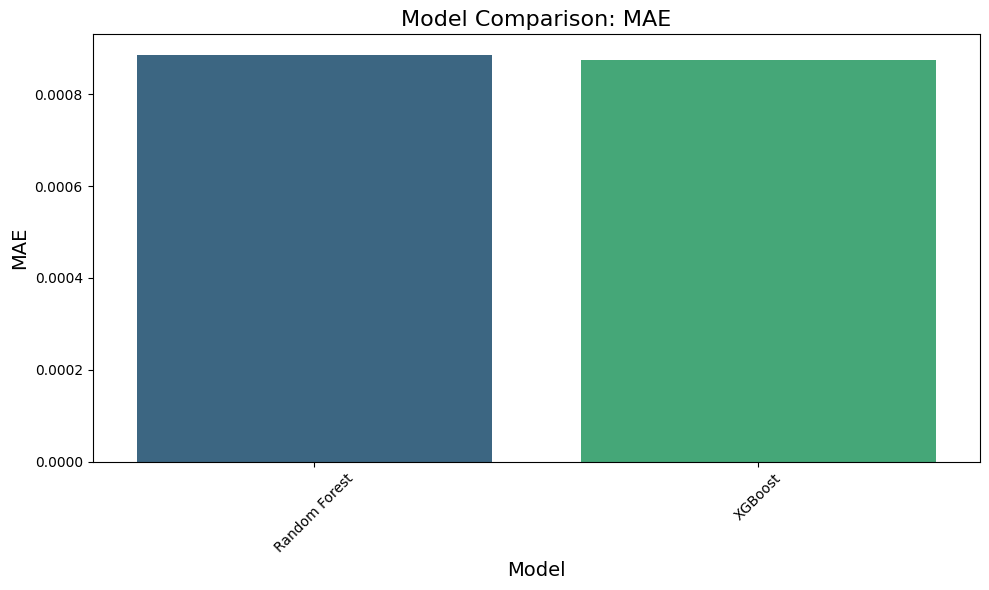

In [42]:

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='viridis')

plt.title('Model Comparison: MAE', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Plot R² as a bar chart

/tmp/ipykernel_107386/1055435227.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R²', palette='viridis')


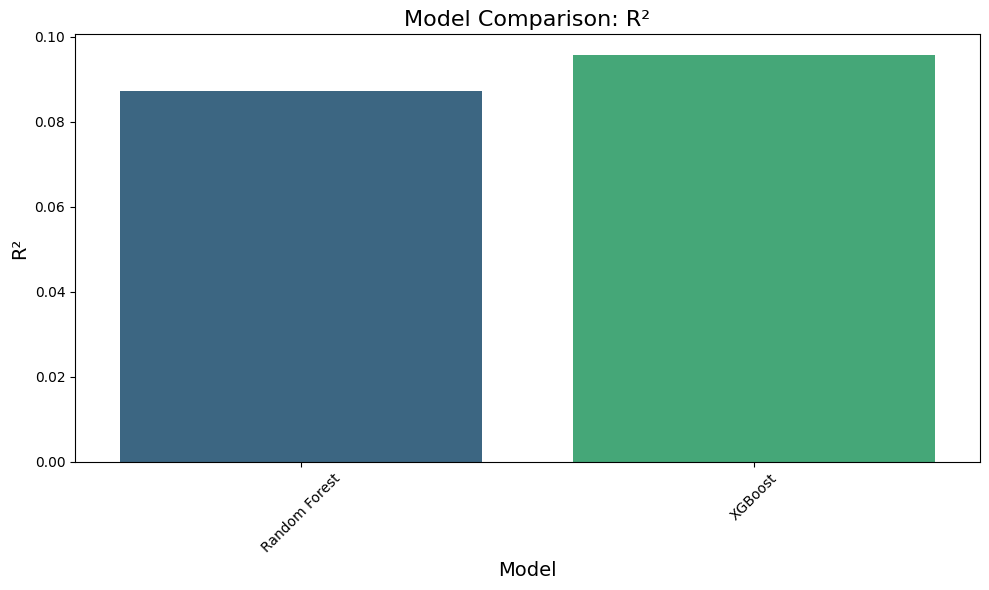

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='R²', palette='viridis')

plt.title('Model Comparison: R²', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Sample predictions

In [56]:
print("Price Min:", price_min)
print("Price Max:", price_max)

Price Min: 1
Price Max: 98900000


In [75]:
rf_predictions = rf_model.transform(final_test_data)
gbt_predictions = cv_gbt_model.transform(final_test_data)

In [76]:
from pyspark.sql.functions import monotonically_increasing_id

final_test_data2_indexed = final_test_data.select("Price").withColumn("id", monotonically_increasing_id())
rf_predictions_indexed = rf_predictions.select("prediction").withColumnRenamed("prediction", "RF_Prediction").withColumn("id", monotonically_increasing_id())
gbt_predictions_indexed = gbt_predictions.select("prediction").withColumnRenamed("prediction", "GBT_Prediction").withColumn("id", monotonically_increasing_id())

combined_df = final_test_data2_indexed.join(rf_predictions_indexed, "id").join(gbt_predictions_indexed, "id")
combined_df = combined_df.drop("id")
combined_df.show(10)

+------------+--------------------+--------------------+
|       Price|       RF_Prediction|      GBT_Prediction|
+------------+--------------------+--------------------+
|         0.0|8.622232492447859E-4|6.741613440170983E-4|
|         0.0|8.445608784199556E-4|7.080599271763445E-4|
|         0.0|0.001544718140912...|0.001389767062696...|
|         0.0|0.001369814278544...|0.001149583689202...|
|1.4155712E-7| 7.77695588223083E-4| 6.58628768220605E-4|
|1.0010111E-6|8.333398727798184E-4|6.652869463855481E-4|
|1.0010111E-6|0.002685622324380867|0.002889732369098301|
|1.5065723E-6|8.096543997064395E-4|6.383083127675345E-4|
|2.0121336E-6|8.879710450347591E-4|6.922502915113749E-4|
|2.0121336E-6|0.008299066307092203|0.014360001212054555|
+------------+--------------------+--------------------+
only showing top 10 rows



####  Store as a Delta table

In [ ]:
DeltaDataPath = "hdfs://namenode:9000/user/ubuntu/FinalProject/Delta_trainData"
final_train_data.write.format("delta").mode("overwrite").save(DeltaDataPath)

### Use the test data as a new data for the updating part

In [ ]:
Newdata = "hdfs://namenode:9000/user/ubuntu/FinalProject/Delta_testData"
final_test_data.write.format("delta").mode("overwrite").save(Newdata)

In [ ]:
####################################Update delta with new data(increremental) ##########################################

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from delta.tables import DeltaTable


spark = SparkSession.builder \
    .appName("Incremental Model Update with Delta") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

delta_train_data = spark.read.format("delta").load(DeltaDataPath)
new_data_path = spark.read.format("delta").load(Newdata)

# Step 1: Ingest New Data and Existing Data from Delta
new_data_df = spark.read.csv(new_data_path, header=True)


if DeltaTable.isDeltaTable(spark, delta_train_data):
    existing_data_delta_table = DeltaTable.forPath(spark, final_train_data)
    existing_data_df = existing_data_delta_table.toDF()
else:
    existing_data_df = None

# Step 2: Data Comparison
if existing_data_df is None or existing_data_df.rdd.isEmpty():
    print("No existing data found, saving new data as the initial dataset.")
    new_data_df.write.format("delta").mode("overwrite").save(delta_train_data)
else:
    new_data_df.createOrReplaceTempView("new_data")
    existing_data_df.createOrReplaceTempView("existing_data")

    delta_updates_df = spark.sql("""
        SELECT new_data.*
        FROM new_data
        LEFT ANTI JOIN existing_data
        ON new_data.ID = existing_data.ID
    """)

    if delta_updates_df.rdd.isEmpty():
        print("No new data available for updating.")
    else:
        print("New data detected, updating Delta table and model...")

        # Step 3: Merge new data into the existing Delta table (only append new rows)
        existing_data_delta_table.alias("existing") \
            .merge(
                delta_updates_df.alias("new"),
                "existing.ID = new.ID"  # Assume 'ID' is the unique identifier
            ) \
            .whenNotMatchedInsertAll() \
            .execute()

        # Step 4: Model Update Logic
        combined_data_df = existing_data_delta_table.toDF()

        feature_columns = ['Year', 'Month', 'PropertyType_S', 'PropertyType_T', 'PropertyType_F', 'Old_New', 'City_Label', 'Duration']
        feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
        final_train_data = feature_assembler.transform(combined_data_df)

        rf = RandomForestRegressor(featuresCol='features', labelCol='Price')
        rf_pipeline = Pipeline(stages=[rf])

        # Fit the model with updated data
        rf_model = rf_pipeline.fit(delta_train_data)

        rf_model.save("hdfs://namenode:9000/user/ubuntu/FinalProject/updated_model")
        print("Model updated successfully.")

spark.stop()